In [2]:
import matplotlib.pyplot as plt
import numpy as np
import csv
%matplotlib inline

In [3]:
def read_imag_values(file):
    result = []
    with open(file) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for index, row in enumerate(reader):
            result.append([float(element) for element in row])
    return(result)

In [4]:
def transform_to_density(b_values, Ic_values, y_values):
    #phi0 = 2.067e-15 #in T*m**2
    #W = 1.771e-8 # in m, scaled system size
    #L = 4.92e-9 # in m, scaled system size

    #omega = 2 * np.pi
    W = 360 # in m, scaled system size
    L = 100 # in m, scaled system size
    omega = 2 * np.pi /W
    
    phi_values = b_values * W * L 
    dPhi = phi_values[1] - phi_values[0]
    maxPhi = phi_values[-1]
    
    #dB = b_values[1] - b_values[0]

    real, imag = Ic_values
    
    Jy_values = []
    for y in y_values:
        Jy_real = 0
        Jy_imag = 0
        for k, phi in enumerate(phi_values):
        #for k, b in enumerate(b_values):
            Ic_real = real[k] #Fourier coefficient
            Ic_imag = imag[k]
            Jy_real += np.cos(np.pi * phi / (2 * maxPhi))**0.5 *(Ic_real * np.cos(omega * phi * y) - Ic_imag * np.sin(omega * phi * y)) * dPhi
            Jy_imag += np.cos(np.pi * phi / (2 * maxPhi))**0.5 *(Ic_imag * np.cos(omega * phi * y) + Ic_real * np.sin(omega * phi * y)) * dPhi
            
            #Jy_real += (Ic_real * np.cos(omega * b * y) - Ic_imag * np.sin(omega * b * y)) * dB
            #Jy_imag += (Ic_imag * np.cos(omega * b * y) + Ic_real * np.sin(omega * b * y)) * dB
        Jy_abs = np.sqrt(Jy_real**2 + Jy_imag**2)
        #Jy_values.append((Jy_real, Jy_imag))
        Jy_values.append(Jy_abs)
    return(Jy_values)

In [5]:
datafile = '/home/nefta/thesis/results/wg3_2/supercurrent/vsg=0.0-20171025-15:47:01/data.csv'

In [6]:
values = np.asarray(read_imag_values(datafile)).T
absval , realval, imagval = values
maxB = 0.0001
magnetic_field = np.linspace(-maxB, maxB, 1000)


In [7]:
W = 360 # in m, scaled system size
L = 100 # in m, scaled system size

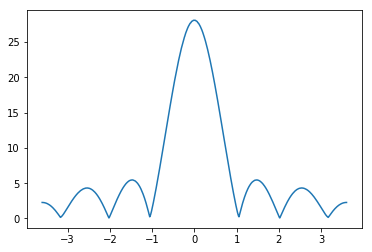

In [8]:
plt.plot(magnetic_field * W * L, values[0])

In [117]:
from scipy.signal import argrelmin, argrelmax

def flip_minima(abs_values, real_values):
    main_peak = np.argmax(abs_values) # index of main peak
    left_min = [0]
    right_min = [main_peak]
    for loc_min in argrelmin(abs_values, order=2)[0]:
        if loc_min < main_peak:
            left_min.append(loc_min)
        else: right_min.append(loc_min)
    left_min.append(main_peak)
    right_min.append(len(abs_values))
    left_min_rev = list(reversed(left_min))
    
    print(left_min, right_min, left_min_rev)
    osc = []
    n = len(left_min)
    for i in range(n - 1):
        #print(n-i - 1, n-i-2)
        for index in range(left_min_rev[n  - i - 1], left_min_rev[n - i - 2]):
            #osc.append((-1)**(i+1) * abs(real_values[index]))
            osc.append((-1)**(n - i) * abs(real_values[index]))

    for i in range(n - 1):
        #print(i, i+1)
        for index in range(right_min[i], right_min[i+1]):
            osc.append((-1)**i * abs(real_values[index]))

    return(osc)
    

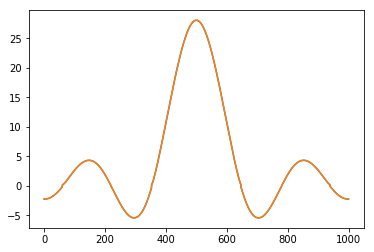

In [108]:
plt.plot(osc)
plt.plot(flip_minima(values[0], values[1]))

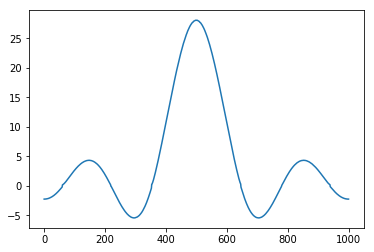

In [10]:
plt.plot(flip_minima(absval, realval))

In [12]:
W = 360
y = np.linspace(-W, W, 500)
density = transform_to_density(magnetic_field, (flip_minima(absval, realval), imagval), y)

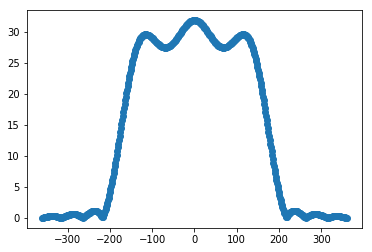

In [13]:
plt.plot(y, density, linestyle='none', marker='o')

In [14]:
file2 = '/home/nefta/thesis/results/wg3_2/supercurrent/vsg=-0.4-20171026-13:46:14/data.csv'
values2 = np.asarray(read_imag_values(file2)).T

#density2 = transform_to_density(magnetic_field, (values[0], values[1]), y)

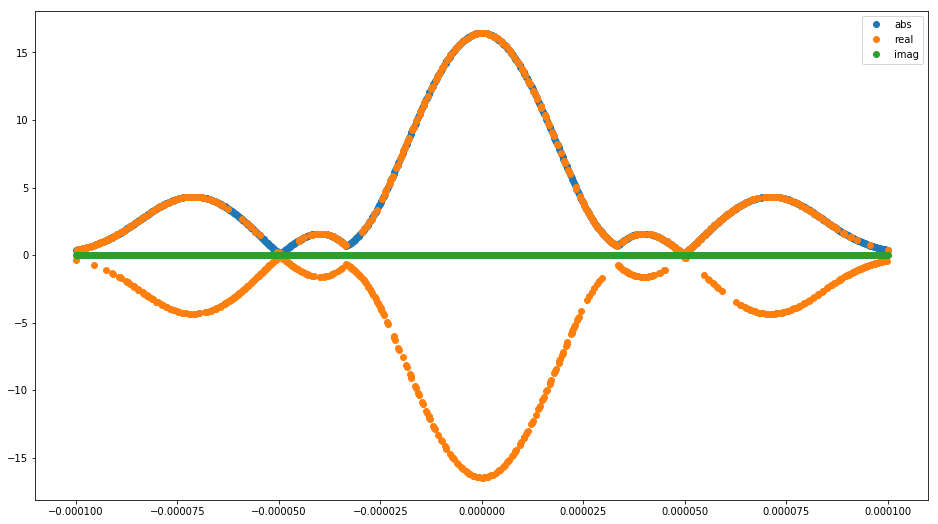

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
for index, labelname in enumerate(['abs', 'real', 'imag']):
    ax.plot(magnetic_field, values2[index], label=labelname, linestyle='none', marker='o')
ax.legend()

In [84]:
np.argmax(values2[0])

499

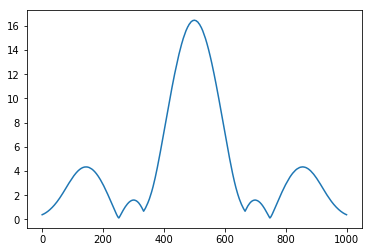

In [105]:
plt.plot(values2[0])

[0, 251, 333, 499] [499, 666, 748, 1000] [499, 333, 251, 0]


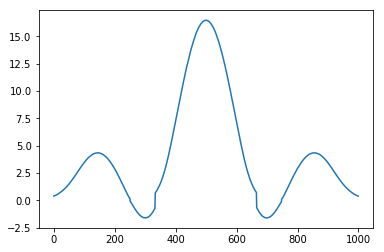

In [118]:
plt.plot(flip_minima(abs_values=values2[0], real_values=values2[1]))

In [110]:
file3 = '/home/nefta/thesis/results/wg3_2/supercurrent/vsg=-0.3-20171026-13:40:36/data.csv'
values3 = np.asarray(read_imag_values(file3)).T

[0, 53, 225, 351, 497] [497, 648, 774, 946, 1000] [497, 351, 225, 53, 0]


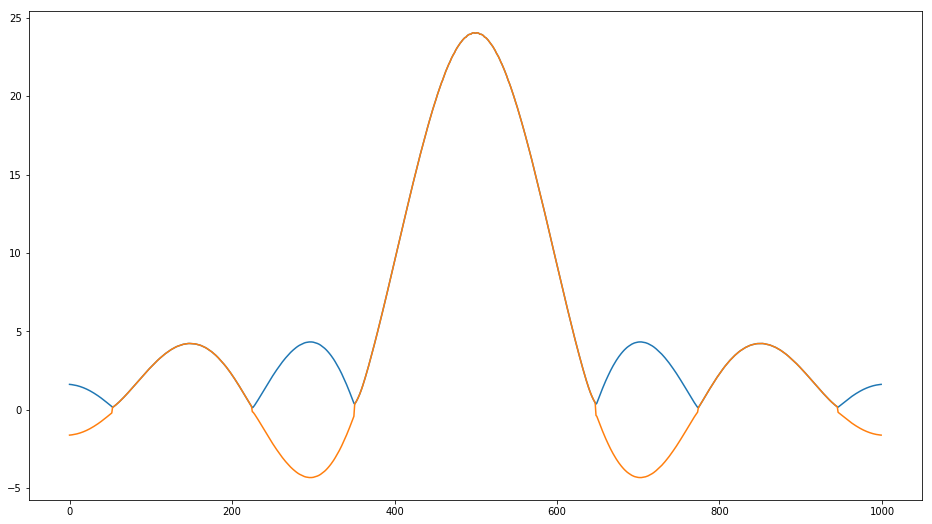

In [119]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(values3[0])
ax.plot(flip_minima(values3[0], values3[1]))

In [115]:
argrelmin(values3[0])

(array([ 53, 150, 225, 351, 648, 774, 849, 946]),)

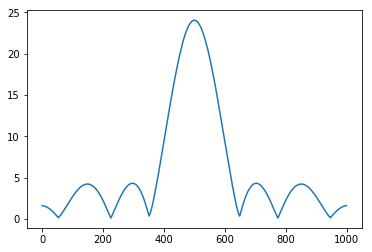

In [116]:
plt.plot(values3[0])